# A Statistical Study of High Frequency Crypto Reactions to FOMC Tone

Author : Thibault Charbonnier \
Date : November 2025 \
Contact : thibault.charbonnier@ensae.fr

---

## Abstract 

This empirical study examines various cryptocurrencies' intraday reactions to U.S. monetary-policy communication and reaches a conclusion consistent with recent literature: cryptos returns appear **orthogonal to monetary policy at high frequency**. Using an NLP-based tone score on FOMC statements and press-conference transcripts to proxy policy “stance”, I find **no statistically significant predictive power** for the sign nor magnitude of returns in various horizons from 10 minutes to 1 hour post statement. However, despite the lack of mean predictability, the conditional distributions differ: events classified by the NLP tone as **most dovish vs. most hawkish** exhibit **statistically significant asymmetry**, suggesting that communication may shape distributional tails rather than average moves. These results should be interpreted with caution given **structural data constraints** : a limited number of FOMC events and the relatively recent, evolving history of liquid cryptocurrencies minute data which restrict the ability to explore extreme-value links more deeply.

---

## Table of contents

- [I. Introduction](#i-introduction)
  - [1. Context & Motivations](#1-context--motivations)
  - [2. Project Contributions](#2-project-contributions)
  - [3. Bibliography](#3-bibliography)

- [II. Dataset](#ii-dataset)
  - [1. Origin](#1-origin)
  - [2. Scraping & Data Acquisition](#2-scraping--data-acquisition)
  - [3. Limits](#3-limits)

- [III. Methodology](#iii-methodology)
  - [1. NLP Sentiment Scoring](#1-nlp-sentiment-scoring)
  - [2. HF Market Reactions](#2-hf-market-reactions)
  - [3. Data Pipeline](#3-data-pipeline)
  - [4. Tone Buckets Distributions](#4-tone-buckets-distributions)
  - [5. Testing Returns Explanations](#5-testing-returns-explanations)
  - [6. Exploring Temporal Response](#6-exploring-temporal-response)
  - [7. Cross-Crypto Diffusion](#7-cross-crypto-diffusion)

- [IV. Executable code](#iv-empirical-results)

- [V. Empirical Results](#iv-empirical-results)

- [VI. Conclusion](#v-conclusion)

---

> ## Note on the project
>
> Building the data infrastructure (scrapers, parsers, event alignment, crypto return engine, nlp scoring) took a fair amount of work.  
> To make it reusable, I’m packaging it as a Python library published on PyPI.
>
> **Package :** `fomc-crypto-hf`  
> **Repo:** `...`

---

## I. Introduction

### 1. Context & Motivations

Monetary‐policy communication is one of the few scheduled macro events that reliably
reprice global risk in minutes. While a vast literature studies high-frequency
reactions of rates, FX and equities to FOMC statements/press conferences,
crypto remains an open laboratory: it trades 24/7, concentrates liquidity in a few
venues, and shows fast microstructure dynamics that are ideal for event studies. At
the same time, central-bank announcements bundle policy and information
components; recent research shows that tone and wording can shift prices even
absent a surprise rate move. This makes NLP a natural tool to extract a continuous
tone signal beyond labels (“hike/cut/hold”).

### 2. Projet Contributions

This project sits at the intersection of high-frequency monetary-policy identification, central-bank communication/NLP, and crypto event studies.

- **Reusable data infrastructure.** : Robust pipeline to download/parse FOMC texts, align high-frequency prices to event timestamps
- **Distributional analysis by tone buckets.** : Clear visuals and statistics to see where distributions differ—center vs. tails.  
- **Statistical tests for explainability.** : Small sample robust inference to quantify whether NLP features explain direction or amplitude of crypto returns.
- **Temporal response exploration.** : Local projections of cumulative returns across horizons to read speed/shape of adjustment

### 3. Bibliography

Here are a few related papers that inspired this work :

- **Gürkaynak, Sack & Swanson (2005)** show that announcements load on at least two factors—*target* (current rate) and *path* (future guidance)—so “actions vs. words” both matter.
- **Nakamura & Steinsson (2018)** argue that some price reactions reflect new macro information revealed by the Fed, not just the policy action.  
- **Jarociński & Karadi (2020)** formalize this separation using sign-restricted identification and multiple high-frequency instruments.   
- **Corbet et al. (2020)** and follow-ups study crypto responses to macro/FOMC news; results vary by asset and period.  
- **Benigno & Rosa (2023)** highlight a “Bitcoin–macro disconnect” in some samples, consistent with our finding of weak mean predictability but meaningful distributional/timing patterns.

## II. Dataset

### 1. Origin

I do not use a prepackaged dataset, I built it. Two main data pillars:

**(A) FOMC communication**
- Statements: the short policy statement posted on the Fed’s website at the decision time (typically around 2:00 p.m.). We parse the full text from the website (https://www.federalreserve.gov/monetarypolicy/fomc_historical_year.htm) to built a statement tone index with a NLP pipeline.
- Press-conference transcripts: Q&A (roughly ~30 minutes after the statement) transcript and prepared remarks. We treat this as an additional information release and compute a tone delta (press − statement).

**(B) Crypto prices**
- Minute-level bars for given cryptocurrencies on a regular grid around each event (\[-x, +y\] minutes).  
- Primary source: Binance historical archives (https://data.binance.vision)
- When symbols were not yet listed or data are incomplete, we use fallback venues (other major exchanges).


### 2. Scraping

**Fed pages**
- We automated retrieval of statement pages and press-conference transcripts directly from the Fed website.  
- The scraper follows the link structure of the archive pages; for each meeting it:
  1. Locates the statement (prefers PDF but falls back to HTML when PDF missing).  
  2. Locates the press-conference transcript (PDF first, then HTML).  
  3. Stores text in cache.
- Because the Fed’s site structure changes across years (pre-/post-2016), the module includes multiple patterns and fallback parsers.

**Crypto data**
- We fetch minute bars around each event window from Binance archives when available.  
- If the asset wasn’t listed yet or the archive is incomplete around the event time, we try fallback sources.
- All series are resampled to a regular minute grid.


### 3. Limits

- **Website heterogeneity over time**: older Fed pages use different layouts and link types (PDF vs HTML, changed paths).  
- **Timestamp reliability**: posted times vs effective times can differ (we used by default 2:00 p.m. and 2:30 p.m. to simplify)
- **Crypto coverage before listing**: for early years some minute data are missing/patchy.
- **Minute-bar quality**: early minutes after listing can be noisy
- **Small-n**: number of meetings is structurally limited


---

## III. Methodology

This section describes how I built the library, how text is turned into tone features, how market reactions are measured, and how we test distributional and predictive relationships in high-frequency setting.

### 1. Data pipeline

The first part of the project was dedicated to build the dataset from scrath including the following steps :

1. **Scrap & parse** Fed texts (Statements + press conference transcripts) : ingest this data properly by cleaning and chunking it.
2. **Analyse sentiment** by scoring texts chunks with a pre-trained LLM via Hugging Face
3. **Load prices** (Binance primary; Coinbase/Bitstamp fallback) : dowload and align high frequency data (minute grid).  
4. **Compute** returns for multiple horizons.
5. **Join** features and reactions

All steps write cache to save time when rerunning.

Here is a diagram of the data pipeline :

![Pipeline Schema](image/Pipeline%20schema.png)



### 2. NLP tone scoring

**Objects.** For each FOMC meeting we collect:
- `statement` (official text at decision time),  
- `press` (press-conference transcript, later on the same day).

**Scoring.** Each document is mapped to a tone score `score ∈ [0,10]` by a fixed NLP model (I used the specialized pre-trained model FOMC-RoBERTa https://huggingface.co/gtfintechlab/FOMC-RoBERTa but the architecture supports other, and possibly our own, LLM model).

**Handling long documents**  \
The text we analyse can be long (q&A in particular with +25 pages easily) so we use the following procedure :
- **Chunking**: chunk the original text in smaller parts of length `max_len` (512 tokens for FOMC-RoBERTa but the parameter is dynamically ajusted according to model selection).  
- **Pooling across chunks**: we perform a simple score mean across the chunks but one could think about a more sophisticated way to aggregate the score (add a weighting scheme for exemple).

**A few words about FOMC-RoBERTa** :

FOMC-RoBERTa is a domain-adapted and fine-tuned variant of RoBERTa trained specifically on Federal Reserve texts—FOMC statements, press-conference transcripts, minutes, and related speeches. We first run domain-adaptive pretraining : continue optimizing the masked-language modeling objective on this in-domain corpus so the encoder internalizes policy jargon (for example “forward guidance”, “balance sheet”). \

The base model RoBERTa itself is a Transformer encoder-only architecture (multi-head self-attention + feed-forward blocks) trained only with masked-language modeling next-sentence prediction. It uses byte-pair encoding tokenization, dynamic masking, large batches, and longer pretraining on massive corpora to learn strong bidirectional contextual representations.

Specific documentation :
- Hugging Face doc : https://huggingface.co/docs/transformers/en/model_doc/roberta
- Original academic paper for RoBERTa : https://arxiv.org/abs/1907.11692
- Domain-adaptive pretraining : https://aclanthology.org/2020.acl-main.740

### 3. Statistical Study

The methodology and results are detailed in the related section : [V. Empirical Results](#iv-empirical-results).


---

## IV. Executable code

The following section will enable you to rerun the computations, a few notes before running the notebook cells :
- The whole library is packaged so it's usable from anywhere juste with the following lines of codes.
- **It's not necessery** to rerun everything as it has been saved into the API's cache
- Inferring a NLP sentiment score for each text is a long process
- Approximate rerun times are indicated before the cell

=> **One can only run the statistical study part without recreating the dataset**


### 0. Basic setup

In [ ]:
# Global imports
import pandas as pd
from src.ingestor.fomc_data import FOMCDownloader
from src.sentiment.nlp_pipeline import NLPPipeline
from src.market.market_processor import MarketProcessor
from src.tools.logging_config import setup_logging, get_logger
from src.utilities import load_cached_sentiments

# Logging system initialization
setup_logging()
logger = get_logger("notebook")

### 1. Full Pipeline Execution

#### 1.1 FOMC Events Scrapping

FOMC statements and press conference transcripts are already loaded in cache (data/_cache/fomc_data). \
**Reruning the following cell is thus not mandatory to perform the other tasks** : \
Scrapping running time ~ **10min**


In [ ]:
FOMCDownloader(start_year=2013, end_year=2016).sync()

### 1.2 Sentiment analysis NLP Pipeline

The NLP Pipeline has already been run and the results are stored in cache (data/_cache/raw_sentiments). \
**The cached results can be used with the argument "use_cache" set to True.** \
Scoring running time ~ **1h45**

In [ ]:
fomc_raw_events = NLPPipeline().run(use_cache=False)

2025-11-03 19:55:42 INFO  Pipeline run started
2025-11-03 19:55:42 INFO  Gathering statement and press conference files...
2025-11-03 19:55:43 INFO  Found 80 valid meetings with both statement & pressconf
2025-11-03 19:55:43 INFO  Found 80 date pairs to process
2025-11-03 19:55:43 INFO  Processing date 20130320
2025-11-03 19:55:44 INFO  	Scoring statement
2025-11-03 19:55:48 INFO  		Number of chunks : 2 | computed in 3.64 seconds
2025-11-03 19:55:48 INFO  	Scoring press conference
2025-11-03 19:56:30 INFO  		Number of chunks : 25 | computed in 41.88 seconds
2025-11-03 19:56:30 INFO  	Date processed: Statement score 0.01, PressConf score 3.76
2025-11-03 19:56:30 INFO  Processing date 20130619
2025-11-03 19:56:33 INFO  	Scoring statement
2025-11-03 19:56:37 INFO  		Number of chunks : 2 | computed in 3.96 seconds
2025-11-03 19:56:37 INFO  	Scoring press conference
2025-11-03 19:57:33 INFO  		Number of chunks : 25 | computed in 56.20 seconds
2025-11-03 19:57:33 INFO  	Date processed: State

### 1.3 Market Data Reactions

Maket Data (Raw format) has already been cached (data/_cache/market_data).\
To construct market reactions around FOMC run the following code with previously built fomc_raw_events. \
To used market cached data use the argument "force_fetch" set to False.

If you're not running the previous cell please execute this one to load cached sentiment data :

In [2]:
fomc_raw_events = load_cached_sentiments()

In [ ]:
processor = MarketProcessor(symbols=["BTCUSDT"],
                            windows=[i for i in range(1, 61)],
                            pre_margin=0)
processor.process_events(events=fomc_raw_events,
                         save_computation=True,
                         force_fetch=False)

### 2. Statistical Study

This section includes the code that generated the plots and the tests displayed in the next section dedicated to the empirical results. \
**If you juste want to see the results, please skip this section.**

#### Preparing the data

In [1]:
import pandas as pd
# Data loading and preparation
from src.quant_analysis.data_prep import add_tone_buckets
# Plots
from src.quant_analysis.plots import plot_buckets_distrib, qq_plot, q_shift_plot, plot_fedfunds_aligned
# Statistical tests
from src.quant_analysis.stats import run_regression, run_logistic_regression, run_skew_bootstrap, run_quantile_shift

df = pd.read_csv("data/_cache/full_sentiment/full_sentiment_cache.csv")
df = add_tone_buckets(
    df=df,
    score_col="score_stmt",
    q=0.25,
    col_name="tone_bucket",
)
print(df.groupby("tone_bucket").size())

tone_bucket
dovish     20
hawkish    20
neutral    40
dtype: int64


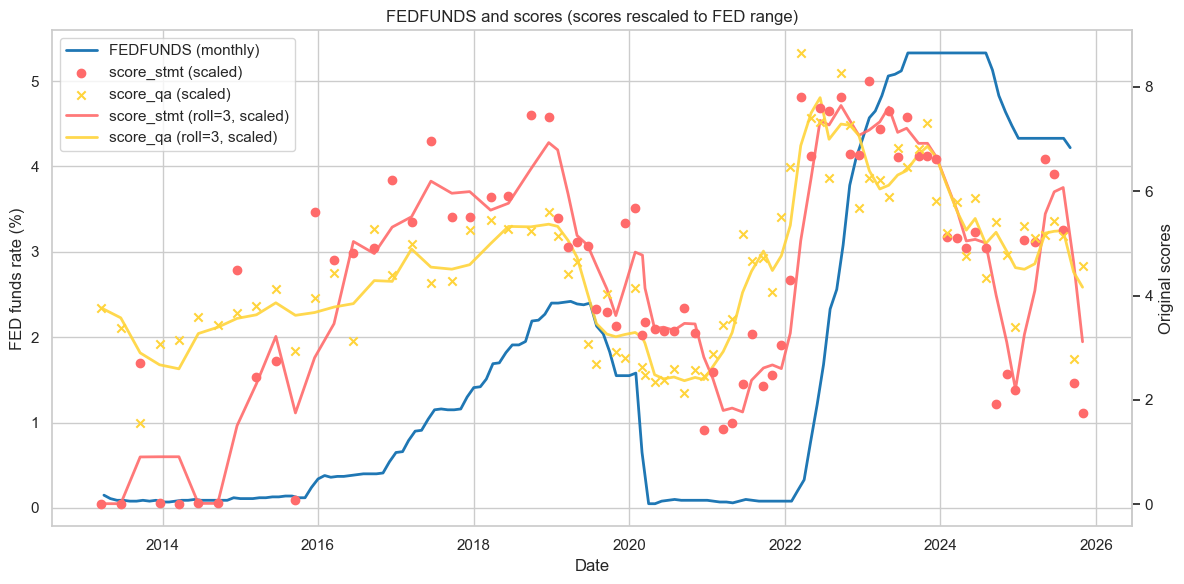

In [2]:
plot_fedfunds_aligned(df=df,
                      fed_csv="data/rates/FEDFUNDS.csv",
                      outpath="outputs/Scores vs FedFunds Rate.png",
                      show_delta=False,
                      plot_mode='both',
                      ma_window=3)

#### Bucket distributions & Skewness

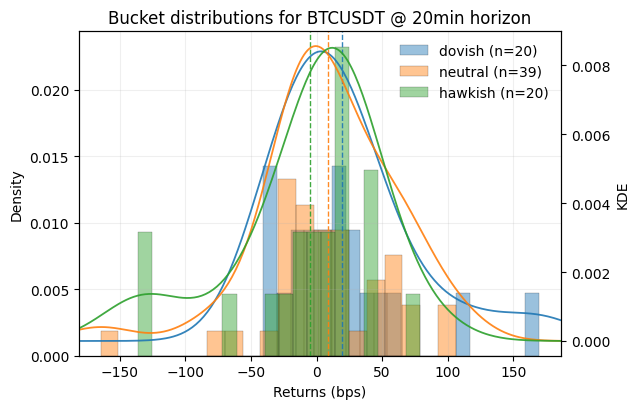

In [2]:
plot_buckets_distrib(
    df=df,
    returns_col="BTCUSDT_20m",
    buckets_col="tone_bucket",
)

In [2]:
res_bootstrap = run_skew_bootstrap(
    distrib_A=df.loc[df["tone_bucket"] == "dovish", "BTCUSDT_20m"].to_numpy(),
    distrib_B=df.loc[df["tone_bucket"] == "hawkish", "BTCUSDT_20m"].to_numpy(),
    B=1000,
    conf_level=0.90
)
print(res_bootstrap)

skew_A       1.587
skew_B      -1.334
skew_diff    2.920
ci_lower     0.887
ci_upper     3.820
dtype: float64


In [2]:
res_quantile_shift = run_quantile_shift(
    distrib_A=df.loc[df["tone_bucket"] == "dovish", "BTCUSDT_20m"].to_numpy(),
    distrib_B=df.loc[df["tone_bucket"] == "hawkish", "BTCUSDT_20m"].to_numpy(),
    B=1000,
    conf_level=0.90
)
print(res_quantile_shift)

   q_level        q_A        q_B     q_diff   ci_lower    ci_upper
0      0.1 -34.363940 -71.693683  37.329742 -19.566423  112.944680
1      0.2 -14.712376 -24.348078   9.635702 -21.597860   65.711538
2      0.5  10.908948  12.757635  -1.848687 -18.263772   25.237261
3      0.8  43.791258  26.482889  17.308370 -14.608082   53.629306
4      0.9  68.321809  38.440439  29.881370 -15.193803  128.897263


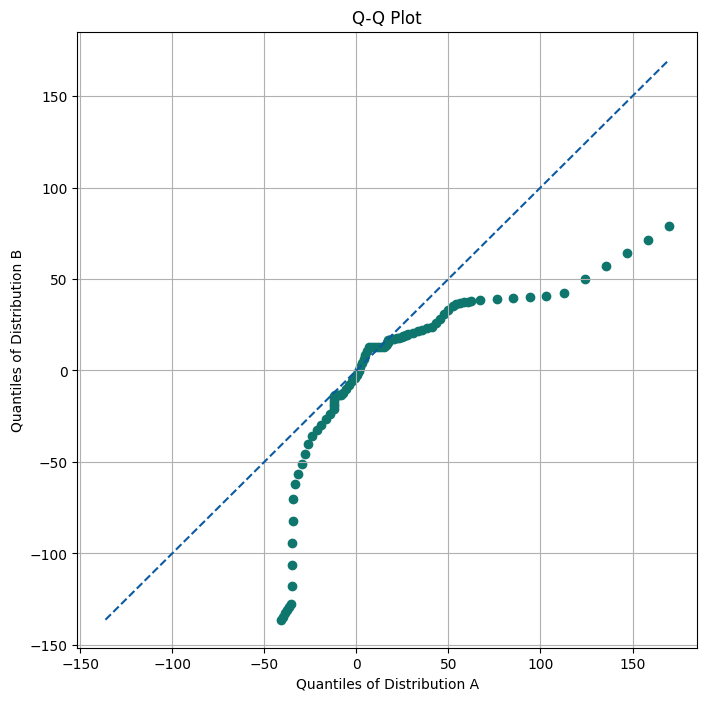

In [2]:
qq_plot(
    distrib_A=df.loc[df["tone_bucket"] == "dovish", "BTCUSDT_20m"].to_numpy(),
    distrib_B=df.loc[df["tone_bucket"] == "hawkish", "BTCUSDT_20m"].to_numpy()
)

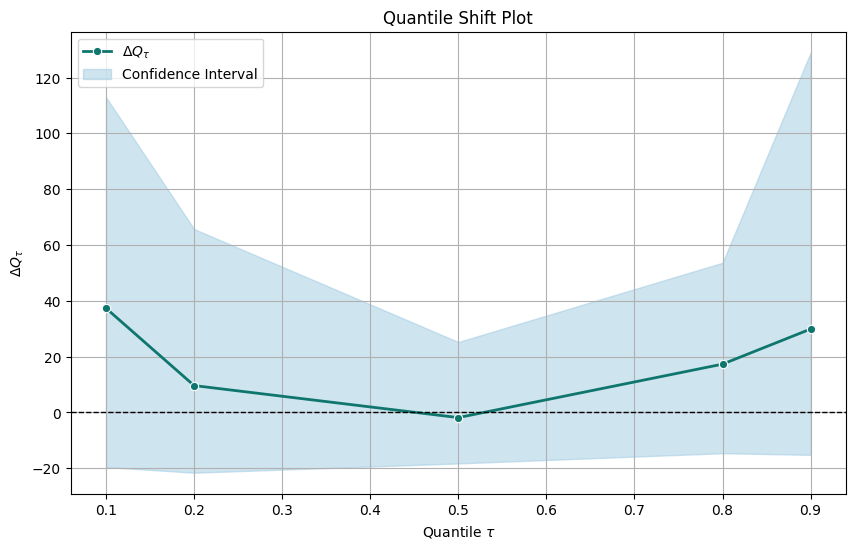

In [3]:
q_shift_plot(
    q_levels=res_quantile_shift["q_level"],
    q_diff=res_quantile_shift["q_diff"],
    q_diff_ci={
        "lower": res_quantile_shift["ci_lower"],
        "upper": res_quantile_shift["ci_upper"]
    }
)

#### Returns explenation with tone

In [4]:
res_regression = run_regression(
    features=df[["score_stmt"]],
    target=df["BTCUSDT_20m"],
)
print(res_regression)

{'r2': 0.031759108884805265, 'n': 79, 'params': {'const': 25.588706384815648, 'score_stmt': -4.041334402602431}, 'pvalues': {'const': 0.048713814692579356, 'score_stmt': 0.12050834075764168}, 'ci95': {'const': (0.14441179732339648, 51.0330009723079), 'score_stmt': (-9.142872628591576, 1.060203823386713)}}


In [2]:
res_logit = run_logistic_regression(
    features=df[["score_stmt"]].apply(lambda x: x - 5.0),
    target=(df["BTCUSDT_20m"] > 0).astype(int)
)
print(res_logit)

{'n': 80, 'auc': 0.5076726342710998, 'hit_rate': 1.0, 'params': {'const': 0.3077329864304816, 'score_stmt': 0.008938185347825325}, 'pvalues': {'const': 0.18896526528288338, 'score_stmt': 0.9288286679288794}, 'ci95': {'const': (-0.15140550271388054, 0.7668714755748437), 'score_stmt': (-0.1871968903488661, 0.20507326104451679)}, 'alpha': 0.3077329864304816, 'beta': 0.008938185347825325, 'p_alpha': 0.18896526528288338, 'p_beta': 0.9288286679288794, 'alpha_ci95': (-0.15140550271388054, 0.7668714755748437), 'beta_ci95': (-0.1871968903488661, 0.20507326104451679)}


---

## V. Empirical Results

This section documents what the data say once the NLP scores are mapped to FOMC events and aligned with high-frequency crypto returns. We proceed in four steps:
- (i) validate that the text-based tone tracks the monetary policy cycle
- (ii) describe how return distributions differ across tone buckets
- (iii) quantify these distributional differences (skew and quantile-shift)
- (iv) test predictability of returns (levels and signs).

Horizons are intraday (<1h) and tone buckets are built from the 25th/75th percentiles of the NLP score (bottom = dovish, top = hawkish, middle = neutral). Confidence intervals are bootstrap percentiles.

### Sanity Check : does the NLP signal co-move with moneraty policy ?

To verify the validity, we rescale the statement and press-conference scores to the range of the Fed Funds target and overlay them with the policy rate over time (Figure 1). The scores rise throughout hiking cycles and fall in easing phases; a short rolling mean closely tracks the slope of the policy path. This establishes that our NLP features capture a meaningful policy-stance signal rather than noise.

> **Figure 1 — Fed Funds vs. rescaled NLP scores (statement and Q&A)**
>
![Fed Funds vs NLP scores](image/NLP_tone_and_fedrates.png)


### Tone buckets and return distributions

We next examine BTC intraday reactions conditioned on tone buckets. Figure 2 overlays bucket-specific histograms (and KDEs): the bulk of returns is centered near zero, but the tails differ : dovish events produce more large positive outcomes, whereas hawkish events exhibit more large negative ones. The neutral bucket is roughly symmetric.

This is a distributional effect: means differ little, but the probability mass in the extremes shifts with tone.

> **Figure 2 - Return distributions by tone bucket (BTC, 20m horizon).**
>
![Bucket Distribs](image/Bucket_distribs_BTC_20m.png)

### Asymmetry

To formalize the visual asymmetry, we estimate the difference in skewness between dovish and hawkish returns using a bootstrap confidence interval. Let $S(.)$ denote skewness (third standardized moment).
We define the delta skewness between the two buckets as :
$$\Delta S = S(R | dovish) - S(R | hawkish)$$

At the 20 min horizon for BTCUSDT we obtain :
$$S_{dovish}=1.59, S_{hawkish}=-1.33, \Delta S=2.92, CI_{90\%}=[0.44, 4.27]$$

-> We conclude that the distribution have a statistically significant delta skew.

### Where the distributions diverge: the quantile-shift

Skewness summarizes asymmetry in a single number. To locate where the densities differ, we compute a shift function defined as :
$$\Delta Q_{\tau} = Q_{\tau}(R | dovish) - Q_{\tau}(R | hawkish)$$

Figure 3 shows $\Delta Q_{\tau}$ with 95% bootstrap bands. The pattern is consistent with Figure 2 : \
$\Delta Q_{\tau} > 0$ at high quantile (heavier right tail for dovish) and $\Delta Q_{\tau} < 0$ at low quantile (heavier left tail for hawish). \
However, with roughly 20 observations per extreme bucket, the confidence bands often straddle zero, so inference at individual quantiles remains inconclusive despite the clear visual trend.

> Figure 3 — Quantile-shift $\Delta Q_{\tau}$ (dovish minus hawkish) with 95% bootstrap CIs.
> 
![Quantile Shift](image/Q_shift_BTC_20_m.png)


A complementary Q–Q plot (Figure 4) bends above the identity line in the right tail and below it in the left tail, reinforcing the same story.

However, Kolmogorov-Smirnov test is not significant at this sample size, which is expected because the differences are concentrated in tails rather than across the entire CDF.

> Figure 4 — Q–Q plot: dovish vs. hawkish returns (BTC, 20m).
> 
![Q-Q Plot](image/QQ_plot_BTC_20m.png)

### Do NLP scores explain return levels?

We run a simple linear model :
$$R_h = \alpha + \beta . s + \epsilon$$

where $R_h$ is the h-minute reaction and $s$ is the centered statement score. \
Using HC1 robust (heteroscedacity) standard errors, coefficients on $s$ are not statistically significant across horizons.
Moreover, $R^2$ is very small (~3%). \
**This indicates no reliable linear relation between tone and intraday return levels.**

### Do scores predict the sign of the reaction?

We estimate a logistic model : 
$$P(R_h > 0) = logit^{-1}(\alpha + \beta . s)$$

AUC of the binary classification hover around 0.50, confirming no directional edge in the mean at these horizons.

---

## VI. Conclusion

The evidence is internally consistent with the litterature :

- **No mean predictability** : Both OLS and logit show that the NLP tone does not explain intraday return levels or signs in a statistically meaningful way.
- **But shape differs** : distributional diagnostics reveal a robust asymmetry: dovish events have heavier right tails, hawkish events have heavier left tails. The Δ-skew is significant; the shift function and Q–Q plots point to the same tail behavior.

**The main limitation is structural sample size**: there are few FOMC meetings and a limited crypto minute history. Consequently, quantile-wise confidence intervals are wide and some tests as Kolmogorov-Smirnov lack power.

### Practical Quant Implications

While these results don’t reveal a tradable edge in the mean at intraday horizon and while the small sample forces caution, I suspect they could still be useful as inputs for risk-aware workflows.
In particular, the tone-linked tail asymmetry might inform :
- (i) conditional position sizing (slightly tighter risk on hawkish events, a bit more tolerance on dovish)
- (ii) monitoring of tail risks around events

These are suggestions that would need larger samples, multi-asset replication, and cluster-robust evaluation before being considered production-ready.